## CSYE 7245 Final Project-PUBG Finish Placement Prediction

- JinZhang  NUID:001899149



---


- ### PortfolioBlog : This is the EDA and Feature Engineering Part for my Project

- #### This notebook contains my own analysis text and code mixwith the code from Kaggle

- #### Details. From the reference in this notebook 

- #### This project is licensed under MIT which is available on the GitHub site which I created :
https://github.com/JinZhang-001899149/Machine_Learning/blob/master/LICENSE


---

### Dataset

***PUBG Finish Placement Prediction***

https://www.kaggle.com/c/pubg-finish-placement-prediction/data

The files of dataset are located in the `data` folder

### ABSTRACT

- My project will involve with a measurement on things like `heals`, `killPoints`, `kills`, `longestKill`,`teamKills`,`vehicleDestroys`,`winPoints`, and other factors predict the winPlacePct which is the rank of a team. And an index will be generated for each factor, which could be seen as a guide to the team on where to put they emphasize during the match. Then a deep learning model will be implemented by several steps, the over 65,000 games' worth of anonymized player data will be reshaped in order to fit in the Machine Learning model.



<a id='Return'></a>
### Table of Contents

[Return to Table ](#Return)

[Introduction ](#In)

[EDA.](#clean)`Idea from this Kaggle` https://www.kaggle.com/deffro/eda-is-fun

[Feature Engineering](#FE)


<a id='In'></a>
### Introduction

**Context**
- You are given over 65,000 games' worth of anonymized player data, split into training and testing sets, and asked to predict final placement from final in-game stats and initial player ratings.

- What's the best strategy to win in PUBG? Should you sit in one spot and hide your way into victory, or do you need to be the top shot? Let's let the data do the talking!

**Challenge**
- In a PUBG game, up to 100 players start in each match (matchId). Players can be on teams (groupId) which get ranked at the end of the game (winPlacePerc) based on how many other teams are still alive when they are eliminated. In game, players can pick up different munitions, revive downed-but-not-out (knocked) teammates, drive vehicles, swim, run, shoot, and experience all of the consequences -- such as falling too far or running themselves over and eliminating themselves.

- You are provided with a large number of anonymized PUBG game stats, formatted so that each row contains one player's post-game stats. The data comes from matches of all types: solos, duos, squads, and custom; there is no guarantee of there being 100 players per match, nor at most 4 player per group.

- You must create a model which predicts players' finishing placement based on their final stats, on a scale from 1 (first place) to 0 (last place).

### Data description
**File descriptions**
train_V2.csv - the training set
test_V2.csv - the test set
sample_submission.csv - a sample submission file in the correct format

**Data fields**
- **DBNOs** - Number of enemy players knocked.
- **assists** - Number of enemy players this player damaged that were killed by teammates.
- **boosts** - Number of boost items used.
- **damageDealt** - Total damage dealt. Note: Self inflicted damage is subtracted.
- **headshotKills** - Number of enemy players killed with headshots.
- **heals** - Number of healing items used.
- **Id** - Player’s Id
- **killPlace** - Ranking in match of number of enemy players killed.
- **killPoints** - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.
- **killStreaks** - Max number of enemy players killed in a short amount of time.
- **kills** - Number of enemy players killed.
- **longestKill** - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
- **matchDuration** - Duration of match in seconds.
- **matchId** - ID to identify match. There are no matches that are in both the training and testing set.
- **matchType** - String identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.
- **rankPoints** - Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.
- **revives** - Number of times this player revived teammates.
- **rideDistance** - Total distance traveled in vehicles measured in meters.
- **roadKills** - Number of kills while in a vehicle.
- **swimDistance** - Total distance traveled by swimming measured in meters.
- **teamKills** - Number of times this player killed a teammate.
- **vehicleDestroys** - Number of vehicles destroyed.
- **walkDistance** - Total distance traveled on foot measured in meters.
- **weaponsAcquired** - Number of weapons picked up.
- **winPoints** - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.) If there is a value other than -1 in rankPoints, then any 0 in winPoints should be treated as a “None”.
- groupId - ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
- **numGroups** - Number of groups we have data for in the match.
- **maxPlace** - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
- **winPlacePerc** - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf # the tensorflow 
#TensorFlow is a Python library for high-performance numerical 
# calculations that allows users to create sophisticated deep learning 
# and machine learning applications. Released as open source software in 2015, 
# TensorFlow has seen tremendous growth and popularity in the data science community.
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.metrics import mean_absolute_error, r2_score



import warnings
warnings.simplefilter(action='ignore', category=Warning)

from sklearn.metrics import mean_squared_error, mean_absolute_error



# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object and col_type.name != 'category' and 'datetime' not in col_type.name:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif 'datetime' not in col_type.name:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

C:\Users\JIN\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
df_train = pd.read_csv('data/train_V2.csv',  nrows=None)
df1_train = reduce_mem_usage(df_train)

df_test = pd.read_csv('data/test_V2.csv',  nrows=None)
df2_test = reduce_mem_usage(df_test)

Memory usage of dataframe is 983.90 MB
Memory usage after optimization is: 498.81 MB
Decreased by 49.3%
Memory usage of dataframe is 413.18 MB
Memory usage after optimization is: 225.31 MB
Decreased by 45.5%


In [3]:
df_train = pd.read_csv('data/train_V2.csv',  nrows=None)


df_test = pd.read_csv('data/test_V2.csv',  nrows=None)


In [4]:
df_train.shape

(4446966, 29)

In [5]:
df_test.shape

(1934174, 28)

In [6]:
df_train.head(10)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,...,0,0.0000,0,0.00,0,0,34.70,1,0,0.0370
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,...,0,0.0000,0,0.00,0,0,13.50,1,1497,0.0000
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,0,2004.0000,0,0.00,0,0,1089.00,6,1500,0.7368
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,...,0,0.0000,0,0.00,0,0,799.90,4,0,0.3704
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.270,0,0,0,74,...,0,0.0000,0,0.00,0,0,65.67,1,0,0.2143


In [7]:
df_train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,...,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446966e+06,4.446965e+06
mean,2.338149e-01,1.106908e+00,1.307171e+02,6.578755e-01,2.268196e-01,1.370147e+00,4.759935e+01,5.050060e+02,9.247833e-01,5.439551e-01,...,1.646590e-01,6.061157e+02,3.496091e-03,4.509322e+00,2.386841e-02,7.918208e-03,1.154218e+03,3.660488e+00,6.064601e+02,4.728216e-01
std,5.885731e-01,1.715794e+00,1.707806e+02,1.145743e+00,6.021553e-01,2.679982e+00,2.746294e+01,6.275049e+02,1.558445e+00,7.109721e-01,...,4.721671e-01,1.498344e+03,7.337297e-02,3.050220e+01,1.673935e-01,9.261157e-02,1.183497e+03,2.456544e+00,7.397004e+02,3.074050e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.551000e+02,2.000000e+00,0.000000e+00,2.000000e-01
50%,0.000000e+00,0.000000e+00,8.424000e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.856000e+02,3.000000e+00,0.000000e+00,4.583000e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.172000e+03,1.000000e+00,1.000000e+00,...,0.000000e+00,1.909750e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.976000e+03,5.000000e+00,1.495000e+03,7.407000e-01
max,2.200000e+01,3.300000e+01,6.616000e+03,5.300000e+01,6.400000e+01,8.000000e+01,1.010000e+02,2.170000e+03,7.200000e+01,2.000000e+01,...,3.900000e+01,4.071000e+04,1.800000e+01,3.823000e+03,1.200000e+01,5.000000e+00,2.578000e+04,2.360000e+02,2.013000e+03,1.000000e+00


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
Id                 object
groupId            object
matchId            object
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
matchDuration      int64
matchType          object
maxPlace           int64
numGroups          int64
rankPoints         int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(19), object(4)
memory usage: 983.9+ MB


<a id='clean'></a>
### Examine missing values
[Return to Table ](#Return)

In [9]:
# Show the number of NAN fields
df_train.isnull().sum(axis=0)

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

- Fellow result brought to our attention that there is one particular player with a 'winPlacePerc' of NaN.
- In this case we assumed is that this match had only one player or something was wrong. 
- We will delete this row from our dataset.

In [10]:
# Check row with NaN value
df_train[df_train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [11]:
# Delete this player
df_train.drop(2744604, inplace=True)

In [12]:
# And he's gone
df_train[df_train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


In [13]:
print('The average winning percentile is {:.3f}, the median is {:.3f}'.format(df_train.winPlacePerc.mean(), df_train.winPlacePerc.median()))

The average winning percentile is 0.473, the median is 0.458


### Ok, now that we have a glimpse of the data, let's explore them. Let's see some interesting fact of this dataset.
- ### The Kill information

In [14]:
print("The average person kills {:.4f} players, 99% of people have {} kills or less, while the most kills ever recorded is {}.".format(df_train['kills'].mean(),df_train['kills'].quantile(0.99), df_train['kills'].max()))

The average person kills 0.9248 players, 99% of people have 7.0 kills or less, while the most kills ever recorded is 72.


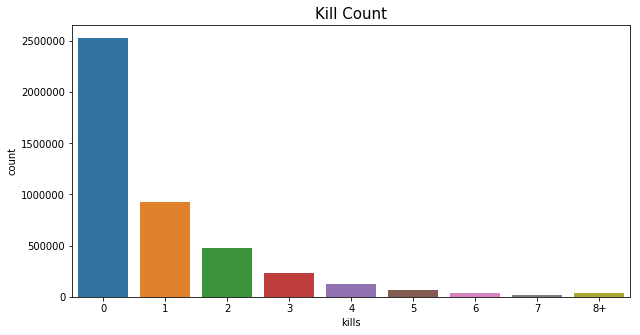

In [15]:
data = df_train.copy()
data.loc[data['kills'] > data['kills'].quantile(0.99)] = '8+'
plt.figure(figsize=(10,5))
sns.countplot(data['kills'].astype('str').sort_values())
plt.title("Kill Count",fontsize=15)
plt.show()

- #### Let's plot the kill counts.  You can see most people can't make a single kill. As the number of kills increases, the value of the cube become lower. This is very reasonable.
- #### So,as for the player can't make a single killed,do they do damage?

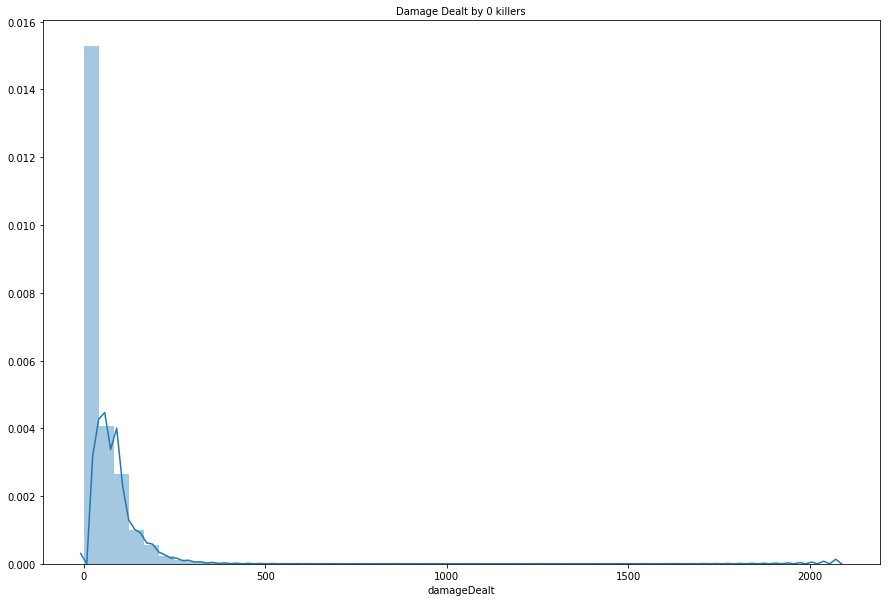

In [16]:
data = df_train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=10)
sns.distplot(data['damageDealt'])
plt.show()

- #### Well, most of them don't. Poor guys
- #### Let's investigate the exceptions.

In [17]:
print("{} players ({:.4f}%) have won without a single kill!".format(len(data[data['winPlacePerc']==1]), 100*len(data[data['winPlacePerc']==1])/len(df_train)))

data1 = df_train[df_train['damageDealt'] == 0].copy()
print("{} players ({:.4f}%) have won without dealing damage!".format(len(data1[data1['winPlacePerc']==1]), 100*len(data1[data1['winPlacePerc']==1])/len(df_train)))

16666 players (0.3748%) have won without a single kill!
4770 players (0.1073%) have won without dealing damage!


- #### Seems like, Those guys have a really great team, their teammates are special forces.  lol. 
- #### Let's group players based on kills (0 kills, 1-2 kills, 3-5 kills, 6-10 kills and 10+ kills).

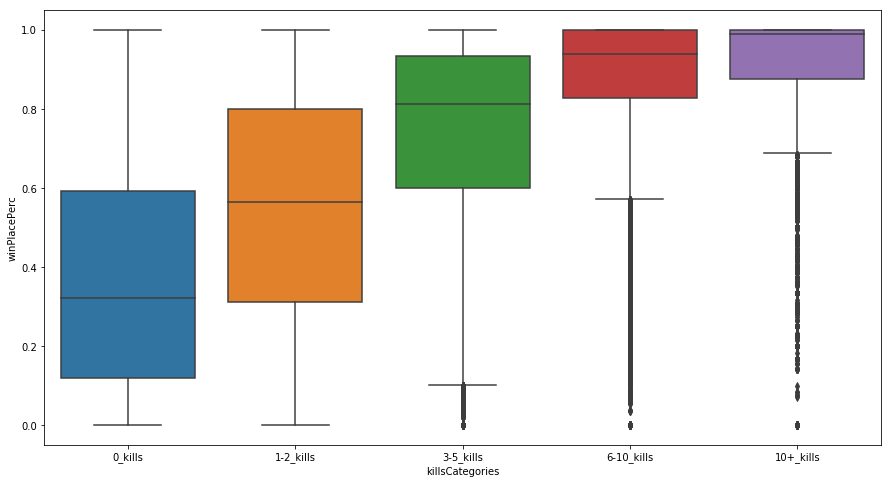

In [18]:
kills = df_train.copy()

kills['killsCategories'] = pd.cut(kills['kills'], [-1, 0, 2, 5, 10, 60], labels=['0_kills','1-2_kills', '3-5_kills', '6-10_kills', '10+_kills'])

plt.figure(figsize=(15,8))
sns.boxplot(x="killsCategories", y="winPlacePerc", data=kills)
plt.show()

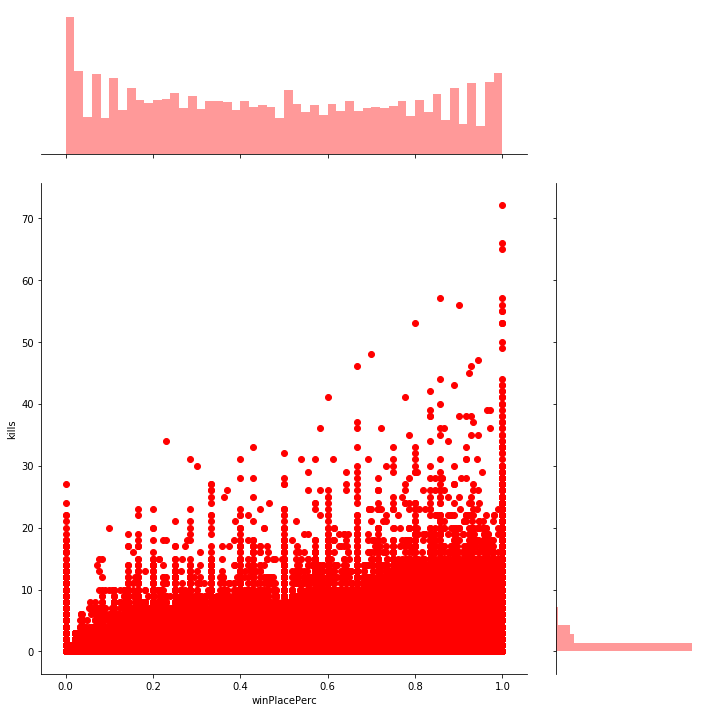

In [19]:
sns.jointplot(x="winPlacePerc", y="kills", data=df_train, height=10, ratio=3, color="r")
plt.show()

- #### Apparently killing has a correlation with winning. more kills the `winPlacePerc` becomes higher. However, there are some outliers. Although those player got many kills but they didn't win. Maybe too focus on killing.


### Next Let's see  how movement effect the `winPlacePerc`
- #### The Runners
- #### The Drivers
- #### The Swimmers 


In [20]:
print("The average person walks for {:.1f}m, 99% of people have walked {}m or less, while the marathoner champion walked for {}m. This guy really a runner".format(df_train['walkDistance'].mean(), df_train['walkDistance'].quantile(0.99), df_train['walkDistance'].max()))

The average person walks for 1154.2m, 99% of people have walked 4396.0m or less, while the marathoner champion walked for 25780.0m. This guy really a runner


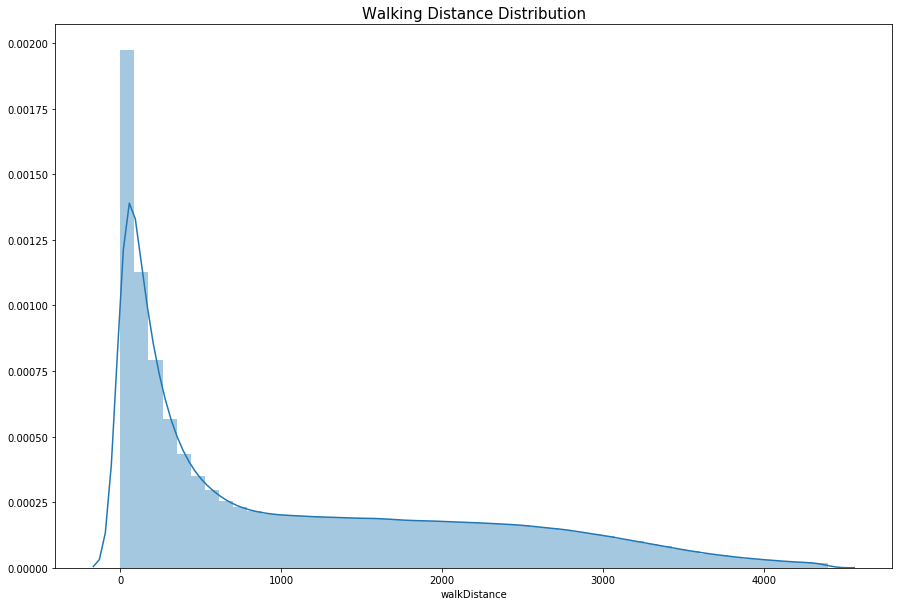

In [21]:
data = df_train.copy()
data = data[data['walkDistance'] < df_train['walkDistance'].quantile(0.99)]
plt.figure(figsize=(15,10))
plt.title("Walking Distance Distribution",fontsize=15)
sns.distplot(data['walkDistance'])
plt.show()

In [22]:
print("{} players ({:.4f}%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).".format(len(data[data['walkDistance'] == 0]), 100*len(data1[data1['walkDistance']==0])/len(df_train)))

99602 players (2.0328%) walked 0 meters. This means that they die before even taking a step or they are afk (more possible).


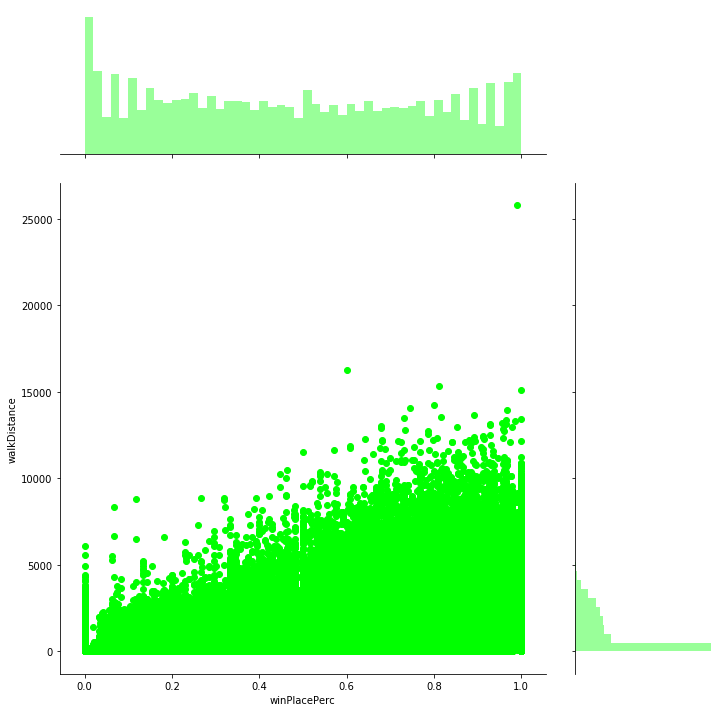

In [23]:
sns.jointplot(x="winPlacePerc", y="walkDistance",  data=df_train, height=10, ratio=3, color="lime")
plt.show()

- #### Apparently walking has a high correlation with `winPlacePerc`

In [24]:
print("The average person drives for {:.1f}m, 99% of people have drived {}m or less, while the champion driver drived  {}m.".format(df_train['rideDistance'].mean(), df_train['rideDistance'].quantile(0.99), df_train['rideDistance'].max()))

The average person drives for 606.1m, 99% of people have drived 6966.0m or less, while the champion driver drived  40710.0m.


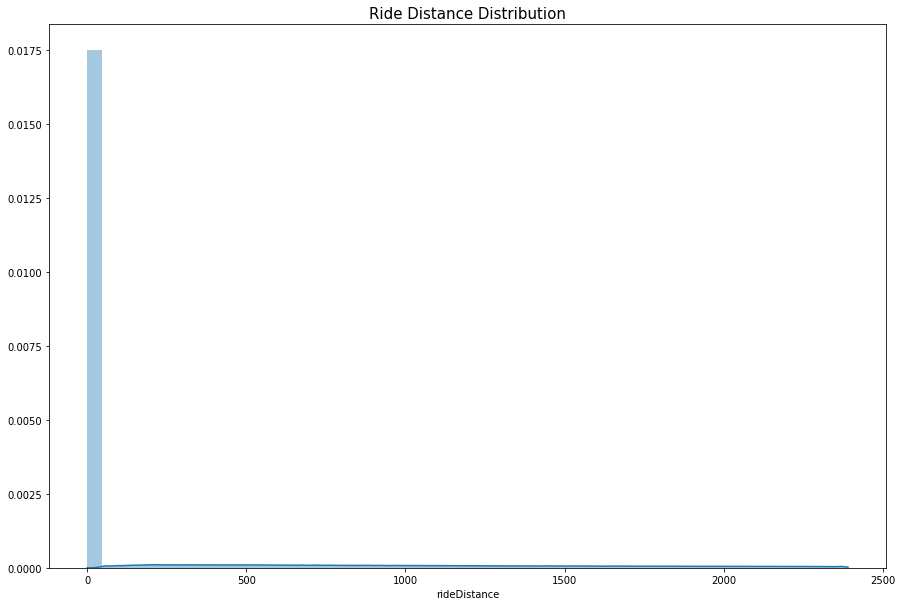

In [25]:
data = df_train.copy()
data = data[data['rideDistance'] < df_train['rideDistance'].quantile(0.9)]
plt.figure(figsize=(15,10))
plt.title("Ride Distance Distribution",fontsize=15)
sns.distplot(data['rideDistance'])
plt.show()

In [26]:
print("{} players ({:.4f}%) drived for 0 meters. This means that they don't have a driving licence yet. They are runner".format(len(data[data['rideDistance'] == 0]), 100*len(data1[data1['rideDistance']==0])/len(df_train)))

3309428 players (23.1022%) drived for 0 meters. This means that they don't have a driving licence yet. They are runner


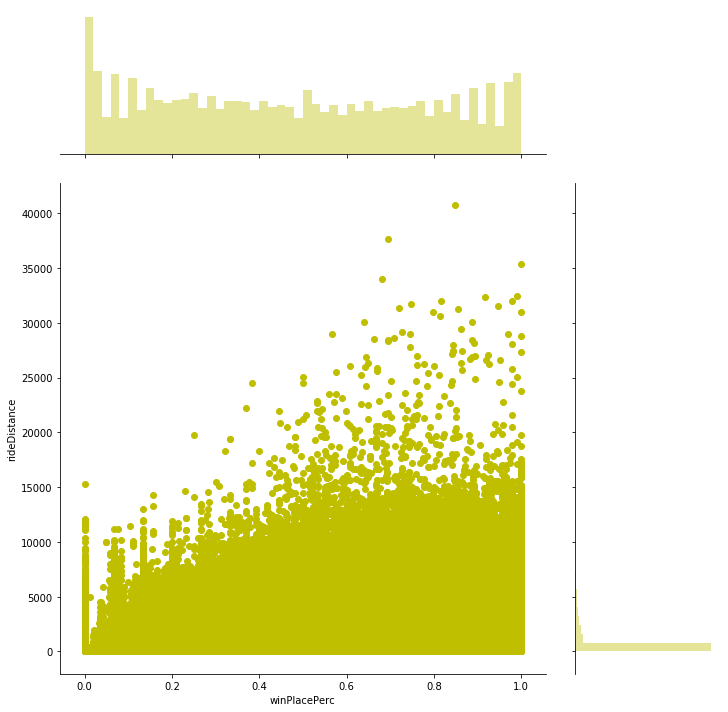

In [27]:
sns.jointplot(x="winPlacePerc", y="rideDistance", data=df_train, height=10, ratio=3, color="y")
plt.show()

- #### There is a small correlation between rideDistance and `winPlacePerc`. But is not significant as the runner does, the slope is more gentle as previous plot

- #### And there is another fact about the vehicle, In the game, if you destroying a vehicle, you will kill the player inside it as well. this means you got more kills this fact should increase the percentage of winning,  Let's check. Is this true or not.

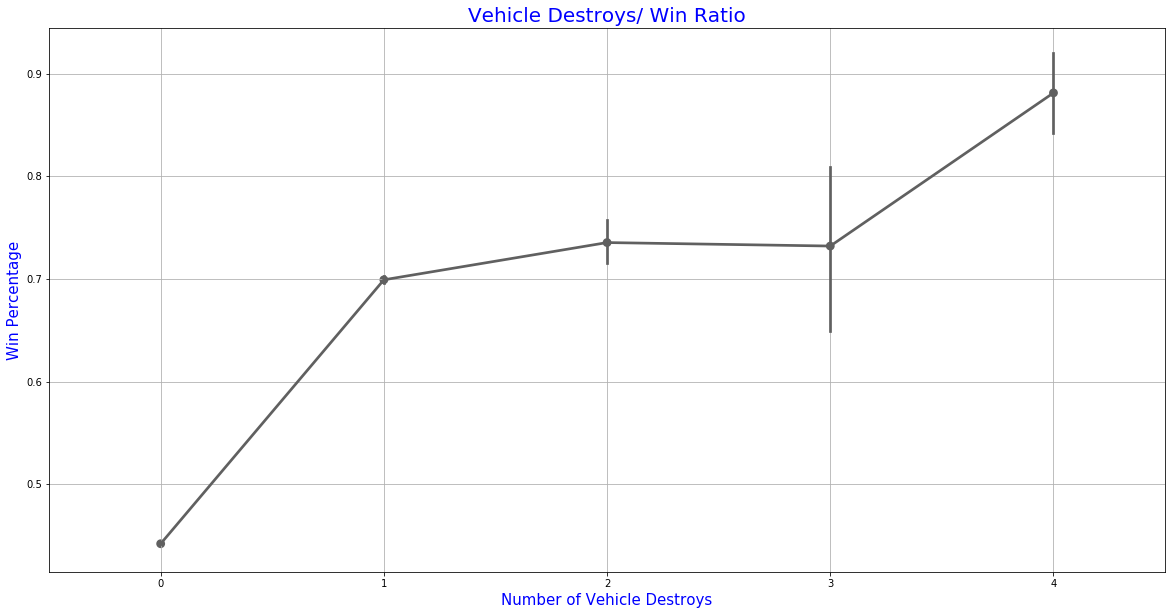

In [28]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='vehicleDestroys',y='winPlacePerc',data=data,color='#606060',alpha=0.8)
plt.xlabel('Number of Vehicle Destroys',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Vehicle Destroys/ Win Ratio',fontsize = 20,color='blue')
plt.grid()
plt.show()

- #### Yes this is true, as you can see the more vehicle you destroy, the `winPlacePerc` increase significantly, those players really got the skill.

- #### And at last, Let's see the last way of movement: Swimming.

In [29]:
print("The average person swims for {:.1f}m, 99% of people have swimemd {}m or less, while the olympic champion swimmed for {}m.".format(df_train['swimDistance'].mean(), df_train['swimDistance'].quantile(0.99), df_train['swimDistance'].max()))

The average person swims for 4.5m, 99% of people have swimemd 123.0m or less, while the olympic champion swimmed for 3823.0m.


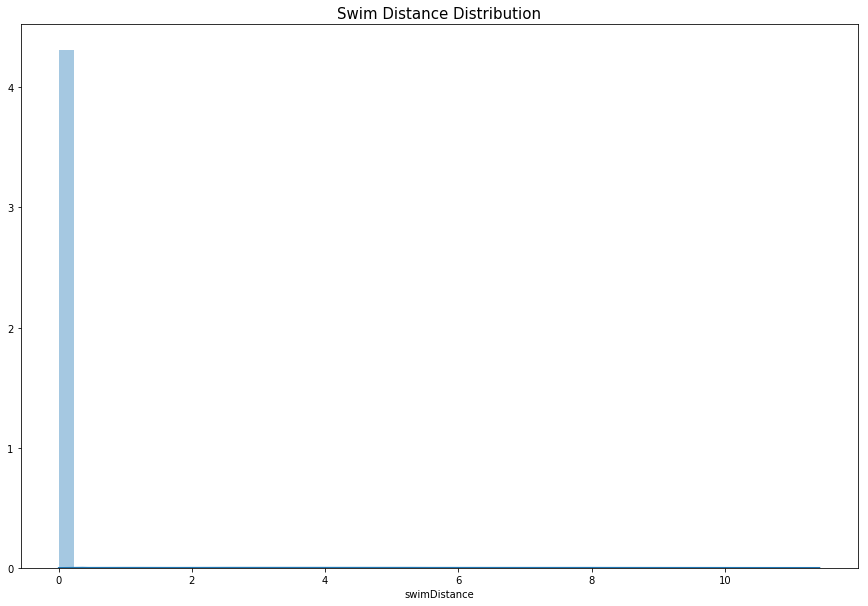

In [30]:
data = df_train.copy()
data = data[data['swimDistance'] < df_train['swimDistance'].quantile(0.95)]
plt.figure(figsize=(15,10))
plt.title("Swim Distance Distribution",fontsize=15)
sns.distplot(data['swimDistance'])
plt.show()

- #### This plot looks like, No one enjoys swimming, let do the same things, group the swimming distances in 4 categories and plot vs `winPlacePerc`.

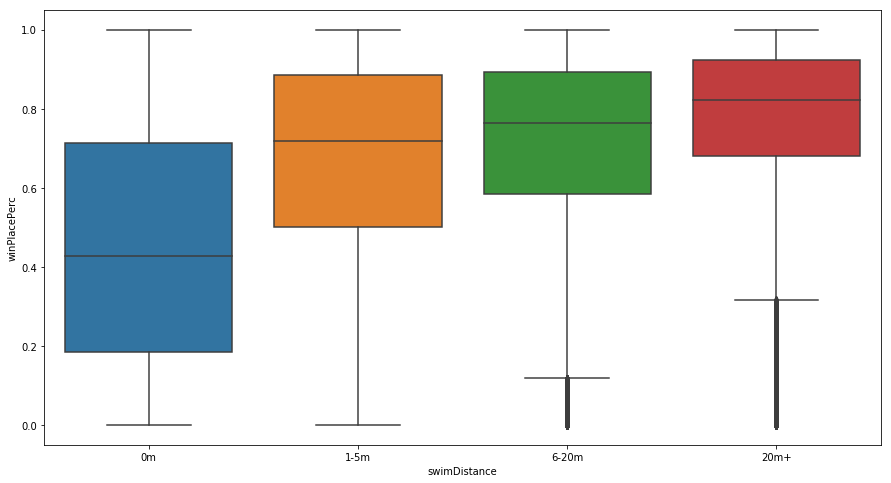

In [31]:
swim = df_train.copy()

swim['swimDistance'] = pd.cut(swim['swimDistance'], [-1, 0, 5, 20, 5286], labels=['0m','1-5m', '6-20m', '20m+'])

plt.figure(figsize=(15,8))
sns.boxplot(x="swimDistance", y="winPlacePerc", data=swim)
plt.show()

- #### It seems that if you swim, you rise to the top, In my experience, if you hide in the water, other players can't hurt you, So If you stay in the right water zoom. you may approach the top. Make sense.

### So far I analysis  the kills and all kinds of movement, next Let's see the other fact in this game `heal` `revival` you teammate, should have a really big correlation with `winPlacePerc`

In [32]:
print("The average person uses {:.1f} heal items, 99% of people use {} or less, while the doctor used {}.".format(df_train['heals'].mean(), df_train['heals'].quantile(0.99), df_train['heals'].max()))
print("The average person uses {:.1f} boost items, 99% of people use {} or less, while the doctor used {}.".format(df_train['boosts'].mean(), df_train['boosts'].quantile(0.99), df_train['boosts'].max()))

The average person uses 1.4 heal items, 99% of people use 12.0 or less, while the doctor used 80.
The average person uses 1.1 boost items, 99% of people use 7.0 or less, while the doctor used 33.


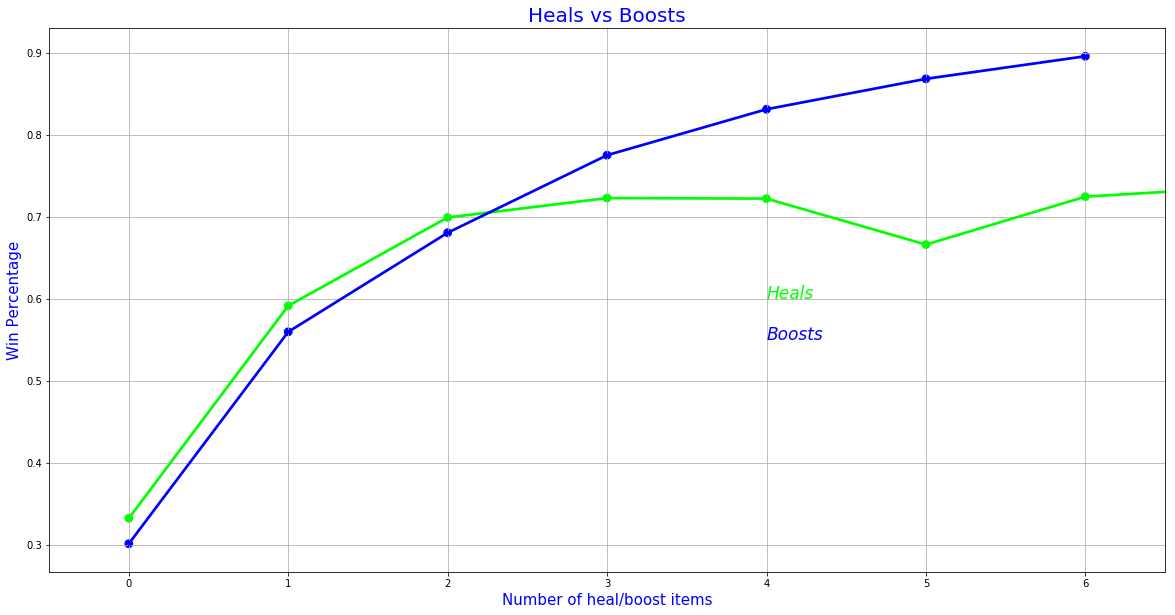

In [33]:
data = df_train.copy()
data = data[data['heals'] < data['heals'].quantile(0.99)]
data = data[data['boosts'] < data['boosts'].quantile(0.99)]

f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='heals',y='winPlacePerc',data=data,color='lime',alpha=0.8)
sns.pointplot(x='boosts',y='winPlacePerc',data=data,color='blue',alpha=0.8)
plt.text(4,0.6,'Heals',color='lime',fontsize = 17,style = 'italic')
plt.text(4,0.55,'Boosts',color='blue',fontsize = 17,style = 'italic')
plt.xlabel('Number of heal/boost items',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Heals vs Boosts',fontsize = 20,color='blue')
plt.grid()
plt.show()

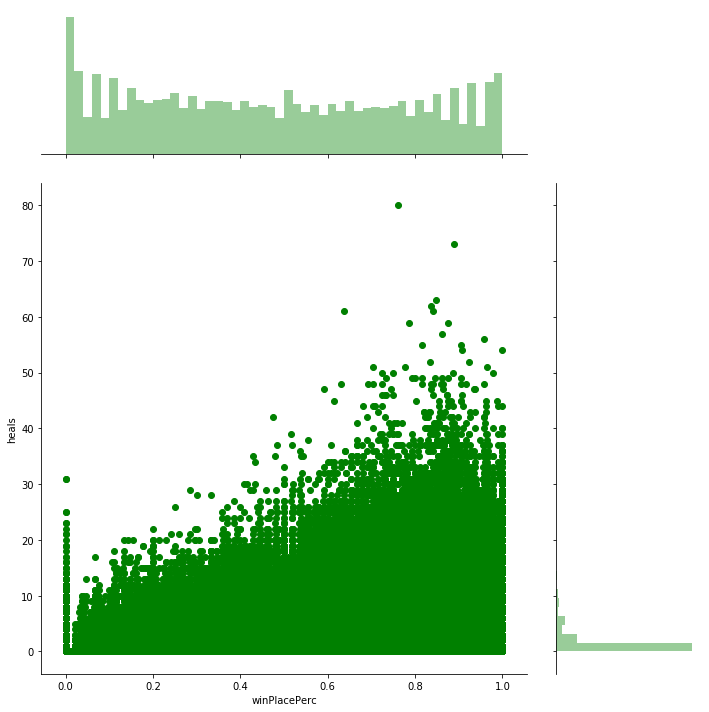

In [34]:
sns.jointplot(x="winPlacePerc", y="heals", data=df_train, height=10, ratio=3, color="Green")
plt.show()

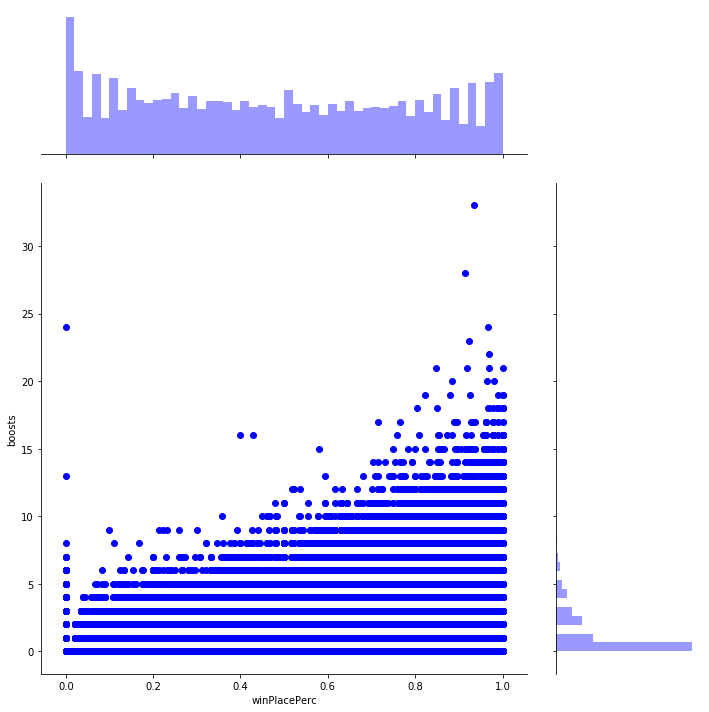

In [35]:
sns.jointplot(x="winPlacePerc", y="boosts", data=df_train, height=10, ratio=3, color="blue")
plt.show()

- #### This is obviously the `healing` and `boosting`, definitely are correlated with `winPlacePerc`. Boosting is more.

- #### In every plot, there is an abnormal behavior when values are 0. This case, that player simplely like a waste the healing resources. I don't know.

<a id='back'></a>
### The matching mode in the game will also greatly affect the `winPlacePerc`. 
- #### There are 3 game modes in the game. 
- #### One can play solo, 
- #### Or with a friend (duo), 
- #### Or with 3 other friends (squad). 
- #### 100 players join the same server, so in the case of duo the max teams are 50 and in the case of squads the max teams are 25.

In [36]:
solos = df_train[df_train['numGroups']>50]
duos = df_train[(df_train['numGroups']>25) & (df_train['numGroups']<=50)]
squads = df_train[df_train['numGroups']<=25]
print("There are {} ({:.2f}%) solo games, {} ({:.2f}%) duo games and {} ({:.2f}%) squad games.".format(len(solos), 100*len(solos)/len(df_train), len(duos), 100*len(duos)/len(df_train), len(squads), 100*len(squads)/len(df_train),))

There are 709111 (15.95%) solo games, 3295326 (74.10%) duo games and 442528 (9.95%) squad games.


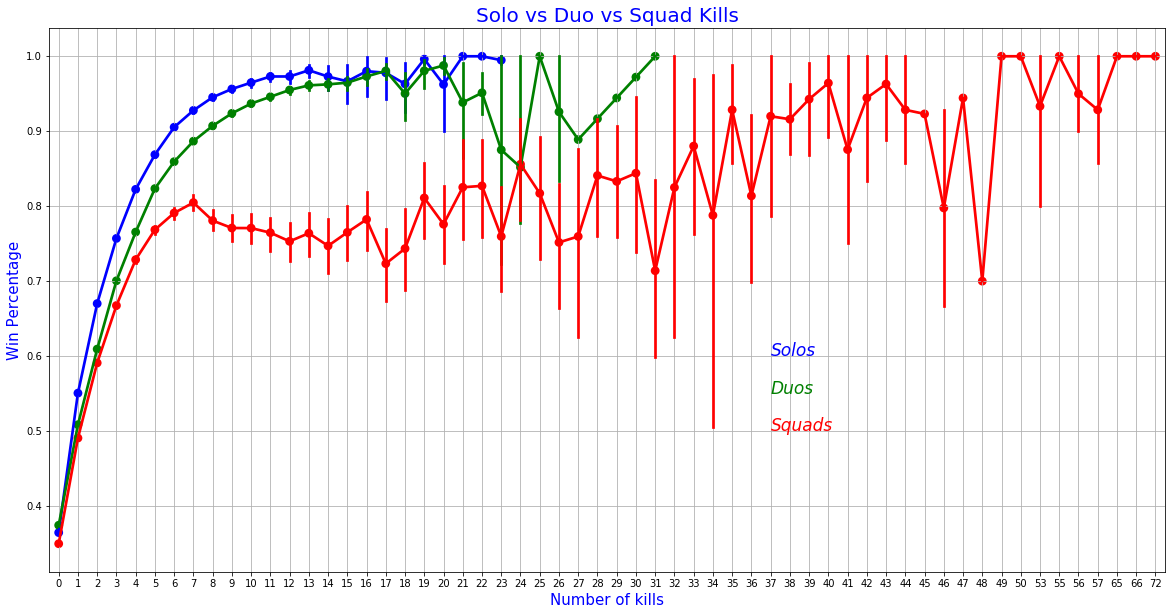

In [37]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='kills',y='winPlacePerc',data=solos,color='blue',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=duos,color='green',alpha=0.8)
sns.pointplot(x='kills',y='winPlacePerc',data=squads,color='red',alpha=0.8)
plt.text(37,0.6,'Solos',color='blue',fontsize = 17,style = 'italic')
plt.text(37,0.55,'Duos',color='green',fontsize = 17,style = 'italic')
plt.text(37,0.5,'Squads',color='red',fontsize = 17,style = 'italic')
plt.xlabel('Number of kills',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Solo vs Duo vs Squad Kills',fontsize = 20,color='blue')
plt.grid()
plt.show()

- #### Very interesting. Solos and duos behave the same, but when playing squads kills don't matter that much.

- #### The attribute `DBNOs` means enemy players knocked. A "knock" can happen only in duos or squads because the teammates have the chance to "revive" the knocked player in a given time. So a knocked player can be revived or die. If he is revived, the next time he will be knocked, his teammates will have less time to revive him.

- #### The attribute `assist` can also happen only in duos or squads. It generally means that the player had an involvement in a kill.

- #### The attribute `revive` also happens in duos or squads.

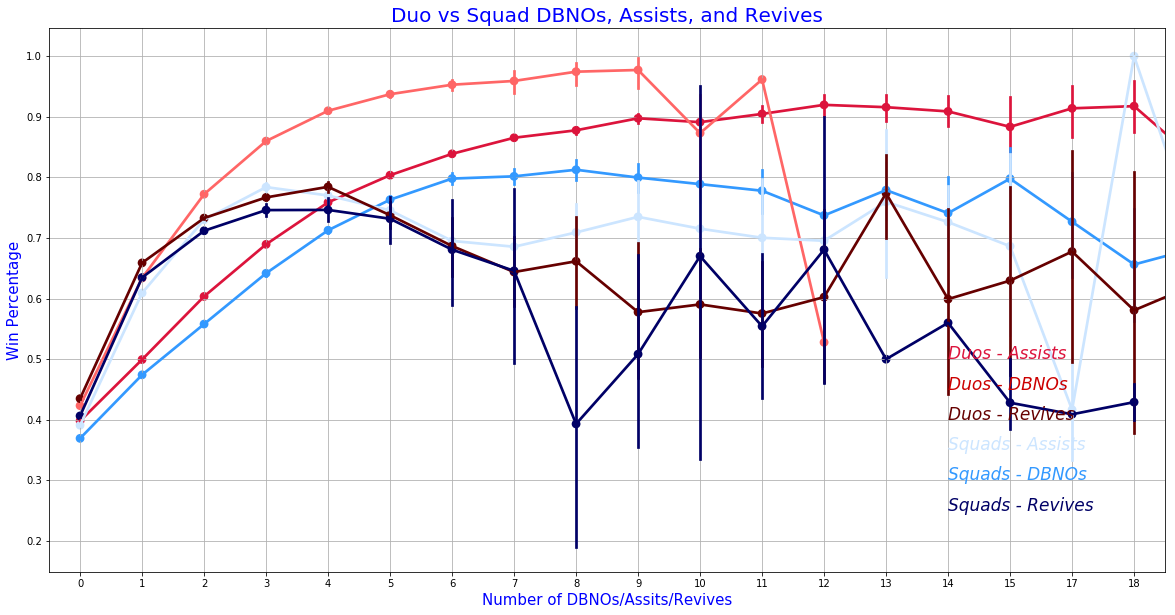

In [38]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.pointplot(x='DBNOs',y='winPlacePerc',data=duos,color='#DC143C',alpha=0.8)
sns.pointplot(x='DBNOs',y='winPlacePerc',data=squads,color='#3399FF',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=duos,color='#FF6666',alpha=0.8)
sns.pointplot(x='assists',y='winPlacePerc',data=squads,color='#CCE5FF',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=duos,color='#660000',alpha=0.8)
sns.pointplot(x='revives',y='winPlacePerc',data=squads,color='#000066',alpha=0.8)
plt.text(14,0.5,'Duos - Assists',color='#DC143C',fontsize = 17,style = 'italic')
plt.text(14,0.45,'Duos - DBNOs',color='#CC0000',fontsize = 17,style = 'italic')
plt.text(14,0.4,'Duos - Revives',color='#660000',fontsize = 17,style = 'italic')
plt.text(14,0.35,'Squads - Assists',color='#CCE5FF',fontsize = 17,style = 'italic')
plt.text(14,0.3,'Squads - DBNOs',color='#3399FF',fontsize = 17,style = 'italic')
plt.text(14,0.25,'Squads - Revives',color='#000066',fontsize = 17,style = 'italic')
plt.xlabel('Number of DBNOs/Assits/Revives',fontsize = 15,color='blue')
plt.ylabel('Win Percentage',fontsize = 15,color='blue')
plt.title('Duo vs Squad DBNOs, Assists, and Revives',fontsize = 20,color='blue')
plt.grid()
plt.show()

- #### Let's ues heatmap to take look at the `Correlation` between variables

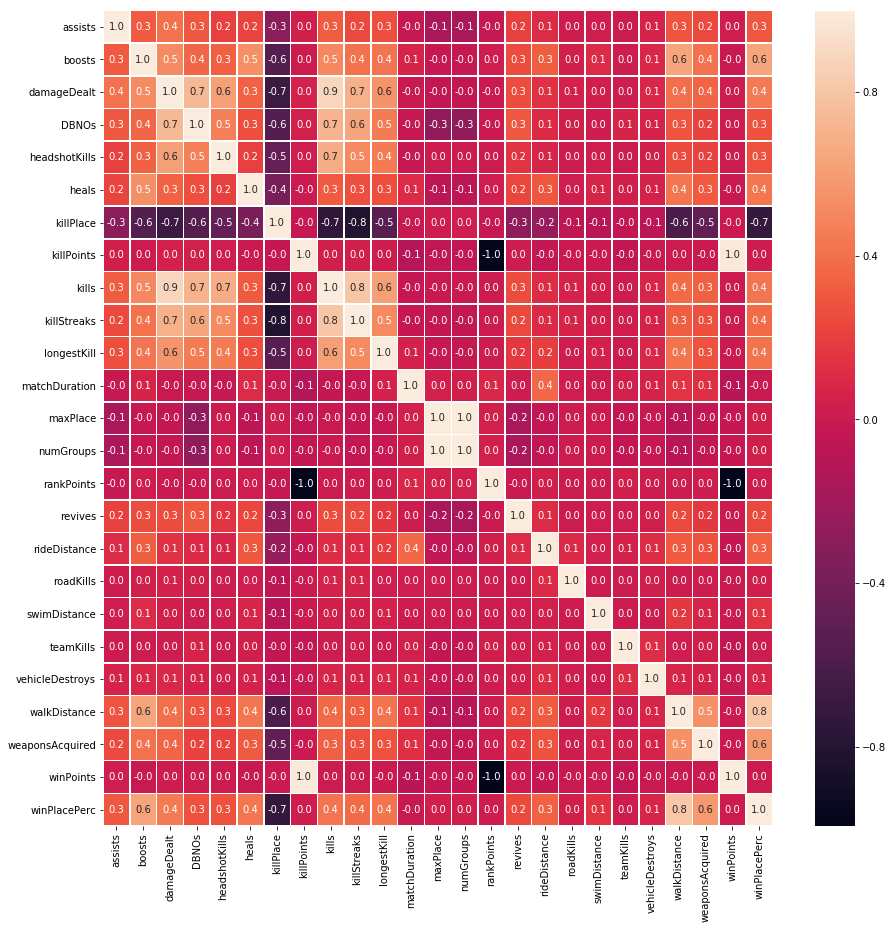

In [39]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(df_train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

- #### In terms of the target variable `winPlacePerc`, there are a few variables high medium to high correlation. The highest positive correlation is `walkDistance` and the highest negative the `killPlace`.

- #### Let's zoom to the top-5 most positive correlated variables with the target.

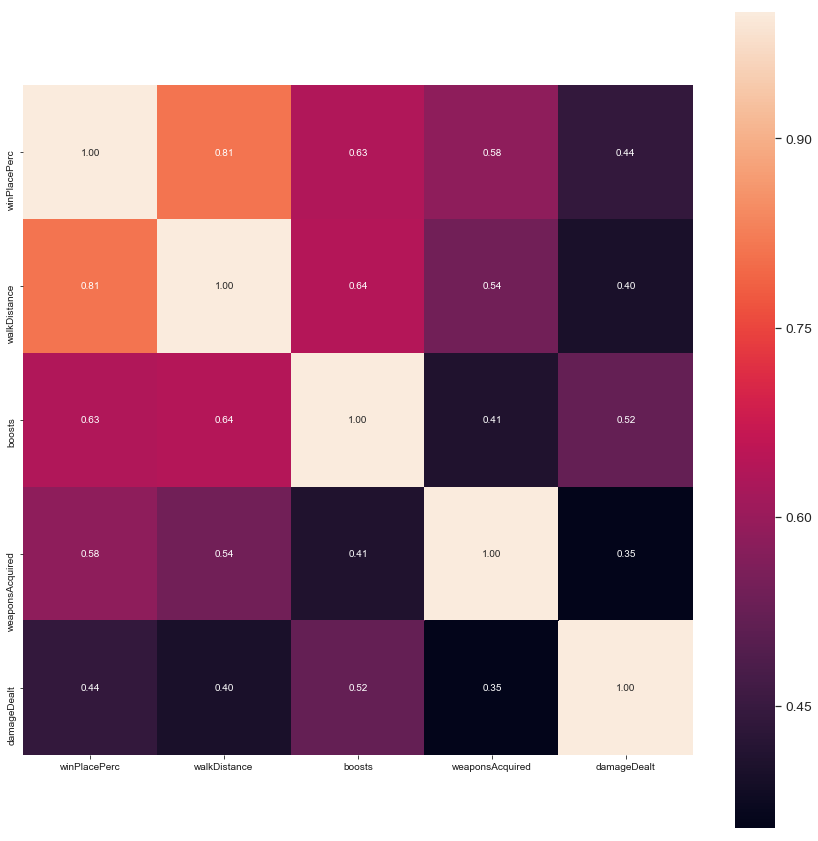

In [40]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(15, 15))
cols = df_train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

- #### Let's plot the above variables and the `killPlace` variable as pairs.

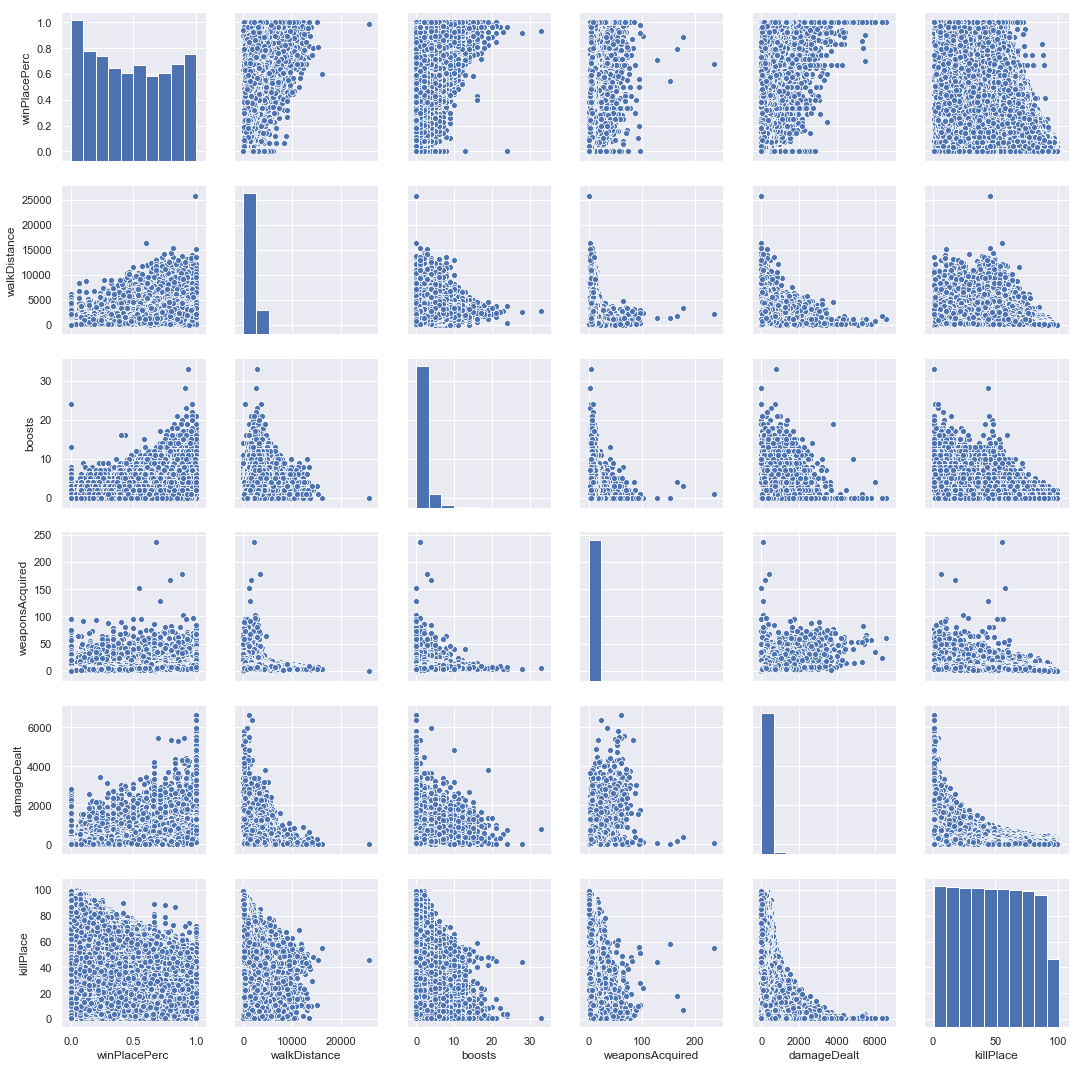

In [41]:
sns.set()
cols = ['winPlacePerc', 'walkDistance', 'boosts', 'weaponsAcquired', 'damageDealt', 'killPlace']
sns.pairplot(df_train[cols], size = 2.5)
plt.show()

<a id='FE'></a>
### Feature Engineering
[Return to Table ](#Return)

- #### A game in PUBG can have up to 100 players fighting each other. But most of the times a game isn't "full". There is no variable that gives me the number of players joined. So lets create one.

In [42]:
df_train['playersJoined'] = df_train.groupby('matchId')['matchId'].transform('count')

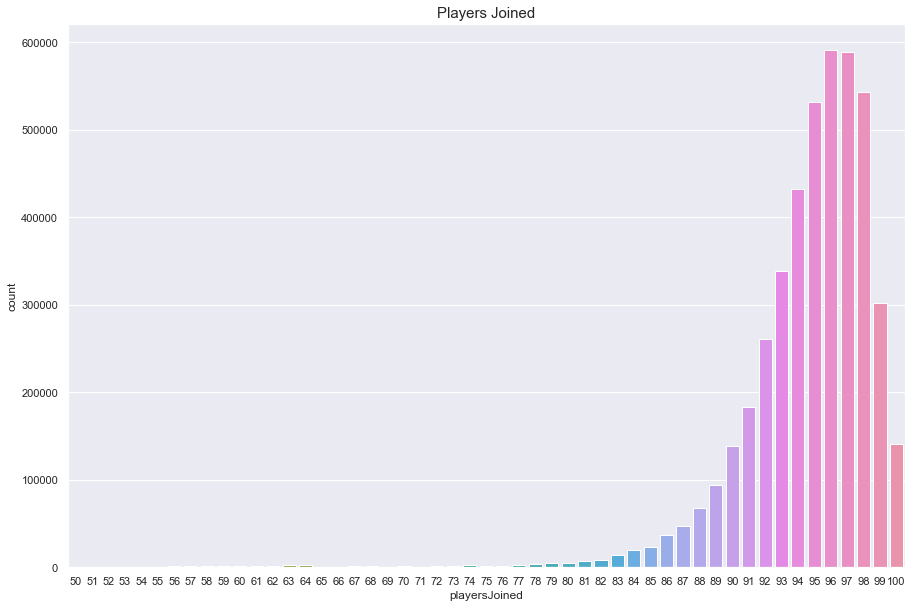

In [43]:
data = df_train.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

- #### Based on the `playersJoined` feature we can create (or change) a lot of others to normalize their values.
- #### This is a really good assumption.
- #### create the `killsNorm` and `damageDealtNorm` features. 
- #### When there are 100 players in the game it might be easier to find and kill someone, than when there are 90 players. 
- #### So this case, normalize the kills in a way that `a kill in 100 players will score 1 (as it is)` 
- #### `In 90 players it will score (100-90)/100 + 1 = 1.1`

In [45]:
df_train['killsNorm'] = df_train['kills']*((100-df_train['playersJoined'])/100 + 1)
df_train['damageDealtNorm'] = df_train['damageDealt']*((100-df_train['playersJoined'])/100 + 1)
df_train[['playersJoined', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm']][5:8]

,playersJoined,kills,killsNorm,damageDealt,damageDealtNorm
5,95,1,1.05,100.000,105.00000
6,97,0,0.00,0.000,0.00000
7,96,0,0.00,8.538,8.87952


- #### Another simple feature is the sum of `heals` and `boosts`.
- #### Also the sum of `total distance` travelled.

In [47]:
df_train['healsAndBoosts'] = df_train['heals']+df_train['boosts']
df_train['totalDistance'] = df_train['walkDistance']+df_train['rideDistance']+df_train['swimDistance']

- #### When using boosting items you run faster. They also help to stay out of the zone and loot more (meaning walking more). 
- #### So let's create a feature boosts per walking distance.`boostsPerWalkDistance` 
- #### Heals don't make you run faster, but they also help to stay out of the zone and loot more. 
- #### So let's create the same feature for heals also.`healsPerWalkDistance`
- #### And for both `heals` and `boost` :`healsAndBoostsPerWalkDistance`

In [49]:
df_train['boostsPerWalkDistance'] = df_train['boosts']/(df_train['walkDistance']+1) 
#The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.

df_train['boostsPerWalkDistance'].fillna(0, inplace=True)

df_train['boostsPerWalkDistance'] = df_train['heals']/(df_train['walkDistance']+1) 
#The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.

df_train['healsPerWalkDistance'].fillna(0, inplace=True)

df_train['healsAndBoostsPerWalkDistance'] = df_train['healsAndBoosts']/(df_train['walkDistance']+1) 
#The +1 is to avoid infinity.

df_train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)

df_train[['walkDistance', 'boosts', 'boostsPerWalkDistance' ,'heals',  'healsPerWalkDistance', 'healsAndBoosts', 'healsAndBoostsPerWalkDistance']][40:45]

,walkDistance,boosts,boostsPerWalkDistance,heals,healsPerWalkDistance,healsAndBoosts,healsAndBoostsPerWalkDistance
40,327.30,1,0.003046,1,0.003046,2,0.006092
41,128.80,0,0.000000,0,0.000000,0,0.000000
42,52.52,0,0.000000,0,0.000000,0,0.000000
43,534.10,1,0.000000,0,0.000000,1,0.001869
44,2576.00,4,0.002328,6,0.002328,10,0.003880


- #### Also, for the `kills`, you kill more means you move a lot and loot more. 
- #### let's create the feature `killsPerWalkDistance`.

In [50]:
df_train['killsPerWalkDistance'] = df_train['kills']/(df_train['walkDistance']+1) 

#The +1 is to avoid infinity, because there are entries where kills>0 and walkDistance=0. Strange.

df_train['killsPerWalkDistance'].fillna(0, inplace=True)

df_train[['kills', 'walkDistance', 'rideDistance', 'killsPerWalkDistance', 'winPlacePerc']].sort_values(by='killsPerWalkDistance').tail(10)

,kills,walkDistance,rideDistance,killsPerWalkDistance,winPlacePerc
4115816,29,0.0,0.0,29.0,0.7500
422093,30,0.0,0.0,30.0,1.0000
3083358,30,0.0,0.0,30.0,0.7500
3057746,31,0.0,0.0,31.0,0.7500
2394021,31,0.0,0.0,31.0,0.5385
2998470,35,0.0,0.0,35.0,1.0000
3062788,36,0.0,0.0,36.0,0.8667
1158891,36,0.0,0.0,36.0,0.5833
1068513,38,0.0,0.0,38.0,0.8333
1702541,43,0.0,0.0,43.0,1.0000


- #### This is fun, see this output, there is some player has 0  walking distance but many kills? Also  has winPlacePerc = 1. 
- #### Those players definitely are cheating.

Earlier in the kernel I did EDA for `Solos`, `Duos` and `Squads`. Lets create a `team` column for them.
[Back to Review ](#back)

In [51]:
df_train['team'] = [1 if i>50 else 2 if (i>25 & i<=50) else 4 for i in df_train['numGroups']]

In [52]:
df_train.head(20)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,playersJoined,killsNorm,damageDealtNorm,healsAndBoosts,totalDistance,boostsPerWalkDistance,healsPerWalkDistance,healsAndBoostsPerWalkDistance,killsPerWalkDistance,team
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.000,0,0,0,60,...,96,0.00,0.00000,0,244.8000,0.000000,0.000000,0.000000,0.000000,2
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.470,0,0,0,57,...,91,0.00,99.70230,0,1445.0445,0.000000,0.000000,0.000000,0.000000,4
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.000,0,0,0,47,...,98,0.00,69.36000,0,161.8000,0.000000,0.000000,0.000000,0.000000,2
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.900,0,0,0,75,...,91,0.00,35.86100,0,202.7000,0.000000,0.000000,0.000000,0.000000,2
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.000,0,0,0,45,...,97,1.03,103.00000,0,49.7500,0.000000,0.000000,0.000000,0.019704,1
5,ff79c12f326506,289a6836a88d27,bac52627a12114,0,0,100.000,1,1,0,44,...,95,1.05,105.00000,0,34.7000,0.000000,0.000000,0.000000,0.028011,2
6,95959be0e21ca3,2c485a1ad3d0f1,a8274e903927a2,0,0,0.000,0,0,0,96,...,97,0.00,0.00000,0,13.5000,0.000000,0.000000,0.000000,0.000000,2
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.538,0,0,0,48,...,96,0.00,8.87952,0,3093.0000,0.000000,0.000000,0.000000,0.000000,1
8,1a68204ccf9891,47cfbb04e1b1a2,df014fbee741c6,0,0,51.600,0,0,0,64,...,97,0.00,53.14800,0,799.9000,0.000000,0.000000,0.000000,0.000000,2
9,e5bb5a43587253,759bb6f7514fd2,3d3031c795305b,0,0,37.270,0,0,0,74,...,97,0.00,38.38810,0,65.6700,0.000000,0.000000,0.000000,0.000000,2


- #### So I created 10 new features. hope it can help the modeling.
- `team`
- `killsPerWalkDistance`
- `boostsPerWalkDistance`
- `healsPerWalkDistance`
- `healsAndBoostsPerWalkDistance`
- `playersJoined` 
- `killsNorm`
- `healsAndBoosts`
- `damageDealtNorm`
- `totalDistance`
- #### Let's store them into new csv file for later model use. 

In [53]:
df_train.to_csv('edadata/train_eda.csv')